# Productionize Model with Explainability via SHAP

In [1]:
import mlrun
from sklearn.datasets import load_iris

# Create MLRun project
project = mlrun.get_or_create_project(name="model-serving-explainability", context="./")

> 2023-03-20 19:05:53,183 [info] loaded project shap from MLRun DB


### Log Model

In [2]:
project.log_model(
    key="iris_model",
    model_file="shap_model.pkl",
    metrics={"loss" : 0.01, "accuracy" : 0.96},
    framework="sklearn",
    algorithm="RandomForestClassifier"
)

In [3]:
model_uri = project.get_artifact_uri("iris_model")
model_uri

'store://artifacts/shap/iris_model'

### Create Model Server

In [4]:
%%writefile serve.py
import mlrun

from cloudpickle import load
from typing import List
import numpy as np
import shap

class ClassifierModelSHAP(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))
        self.explainer = shap.TreeExplainer(self.model)

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
    
    def explain(self, body: dict) -> List:
        """Generate model explaination from sample"""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        shap_values = self.explainer.shap_values(feats)
        return shap_values[result.argmax()].tolist()

Overwriting serve.py


In [25]:
# Create serving function
serve = mlrun.code_to_function(
    name="model-server",
    filename="serve.py",
    kind="serving",
    image="mlrun/mlrun",
    requirements="requirements.txt",
)

serve.add_model(key=f"iris", model_path=model_uri, class_name="ClassifierModelSHAP")

In [26]:
serve.with_requests(mem="1G", cpu=0.1)
serve.with_limits(mem="2G", cpu=0.2)

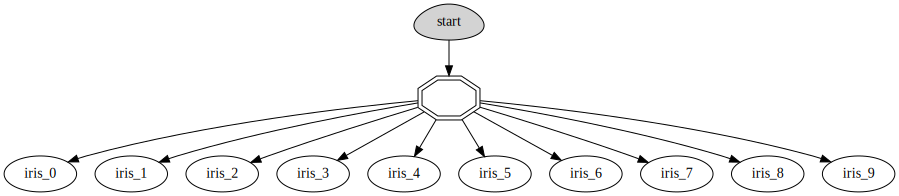

In [27]:
serve.plot()

In [8]:
# print(serve.to_yaml())

In [9]:
addr = serve.deploy()

> 2023-03-08 20:11:47,520 [info] Starting remote function deploy
2023-03-08 20:11:47  (info) Deploying function
2023-03-08 20:11:47  (info) Building
2023-03-08 20:11:47  (info) Staging files and preparing base images
2023-03-08 20:11:47  (info) Building processor image
2023-03-08 20:13:03  (info) Build complete
2023-03-08 20:13:33  (info) Function deploy complete
> 2023-03-08 20:13:33,542 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-shap-model-server.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['shap-model-server-shap.default-tenant.app.us-sales-350.iguazio-cd1.com/']}


In [10]:
addr

'http://shap-model-server-shap.default-tenant.app.us-sales-350.iguazio-cd1.com/'

### Predict

In [16]:
serve.invoke(path="/v2/models/iris/predict", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-03-08 21:41:28,383 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-shap-model-server.default-tenant.svc.cluster.local:8080/v2/models/iris/predict'}


{'id': '9e6257ab-5ac3-47bb-b9ab-0a4f77251fa9',
 'model_name': 'iris',
 'outputs': [0]}

### Explain via SHAP

In [17]:
serve.invoke(path="/v2/models/iris/explain", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-03-08 21:41:36,189 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-shap-model-server.default-tenant.svc.cluster.local:8080/v2/models/iris/explain'}


{'id': 'd6df1328-65ca-49e6-8f86-411ddbf90e30',
 'model_name': 'iris',
 'outputs': [[0.04497215780203216,
   0.014732781996398808,
   0.2917383347609635,
   0.31995672544060544]]}